## Modeling Exercises

For these exercises, I will be using the data from saas.csv.

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings('ignore')

### Acquire Data

In [2]:
saas = pd.read_csv('saas.csv')

In [3]:
saas.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
saas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


### Prepare Data

I'm assuming that amount is the target here. Since there are multiple entries for each day, I'll group by date and sum the Amount for each month. I'm not concerned with Customer_Id, Invoice_Id, or Subscription_Type

In [5]:
saas.Month_Invoiced = pd.to_datetime(saas.Month_Invoiced)

In [8]:
saas = saas.set_index('Month_Invoiced')

In [11]:
saas = saas.sort_index()

In [17]:
sales = pd.DataFrame(saas.groupby(saas.index)['Amount'].sum())

In [19]:
sales.head()

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [20]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-31 to 2017-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Amount  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


<AxesSubplot:xlabel='Month_Invoiced'>

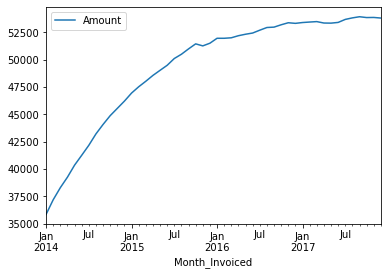

In [21]:
#Take a look at the data to figure out where to split it at
sales.plot()

Since there is 4 years worth of data available, I will split it like so:
* Train: 2014, 2015
* Validate: 2016
* Test: 2017

In [26]:
train = sales['2014':'2015']
train.shape

(24, 1)

In [27]:
validate = sales['2016']
validate.shape

(12, 1)

In [28]:
test = sales['2017']
test.shape

(12, 1)

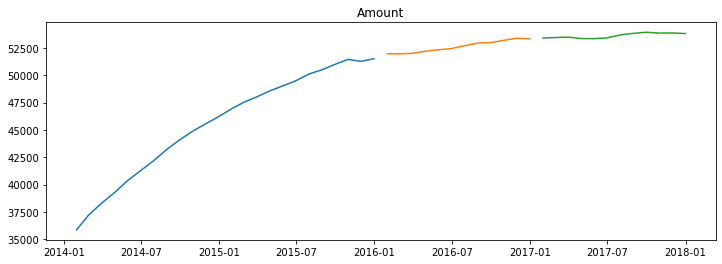

In [25]:
for col in train.columns:  
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.title(col)
    plt.show()

## Forecasting

Some helpful functions:

In [29]:
def evaluate(target_var):
    """
        This function will calculate the RMSE and return it.
    """
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [30]:
def plot_and_eval(target_var):
    """
        This function will use the evaluate function and also plot train 
        and test values with the predicted values in order to compare performance.
    """
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [31]:
#Create an evaluation dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    """
        This function will append evaluation metrics for each model type, target variable, 
        and metric type, along with the metric value into our eval_df data frame object. 
    """
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Simple Average

In [32]:
#Find the average
amount = round(train.Amount.mean(), 2)

In [37]:
def make_predictions():
    yhat_df = pd.DataFrame({'Amount': [amount],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

Amount -- RMSE: 7063


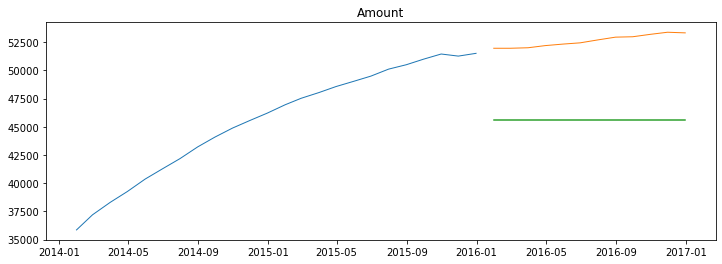

In [38]:
for col in train.columns:
    plot_and_eval(col)

In [39]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [40]:
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7063.0


### Moving Average

In [43]:
periods = [1, 3, 12]

for p in periods:
    amount = round(train['Amount'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'm moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'Amount'
                            )

In [44]:
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7063.0
1,1m moving average,Amount,1222.0
2,3m moving average,Amount,1315.0
3,12m moving average,Amount,3044.0


### Holt's Linear Trend

In [74]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .3, 
                      smoothing_slope = .95, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

Amount -- RMSE: 184


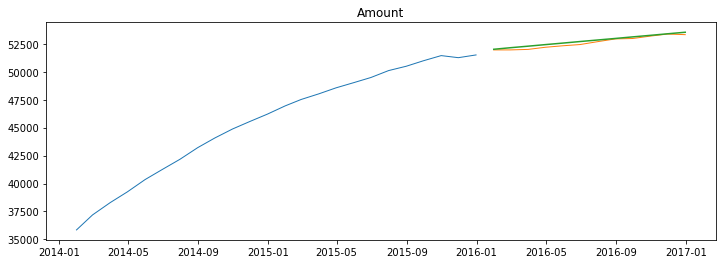

In [75]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [76]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [77]:
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7063.0
1,1m moving average,Amount,1222.0
2,3m moving average,Amount,1315.0
3,12m moving average,Amount,3044.0
4,Holts,Amount,928.0
5,previous year,Amount,5192.0
6,Holts,Amount,184.0


### Prediction Using Previous Cycle

In [78]:
#Add the average yearly difference to the last quarter's values in train
yhat_df = train['2015'] + train.diff(3).mean()

In [79]:
# set yhat_df to index of validate
yhat_df.index = validate.index

Amount -- RMSE: 1409


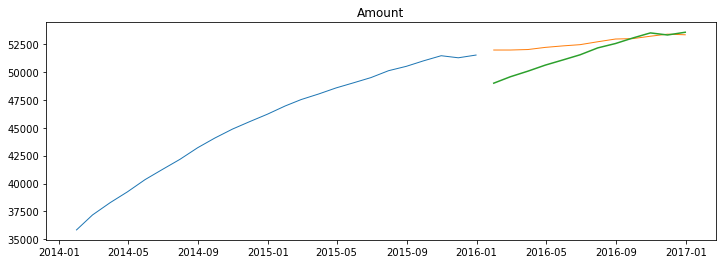

In [80]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous quarter', target_var = col)

In [81]:
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,7063.0
1,1m moving average,Amount,1222.0
2,3m moving average,Amount,1315.0
3,12m moving average,Amount,3044.0
4,Holts,Amount,928.0
5,previous year,Amount,5192.0
6,Holts,Amount,184.0
7,previous quarter,Amount,1409.0
